- In this notebook we will repeat all the preprocessing steps for ONLY the labelled data. Later on we will use the data to build our classification model.

### Data Cleaning

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from collections import Counter
import tqdm
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from afinn import Afinn
import nltk
from wordcloud import WordCloud, STOPWORDS
import gensim
from sklearn.metrics import confusion_matrix as cm
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit

To do:
- TFIDF for both fake and real news
-

In [3]:
dawn = pd.read_csv('dawn-annotated.csv')
dawn.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,1/17/2019,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1.0
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",1/17/2019,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1.0
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,1/17/2019,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1.0
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,1/17/2019,Director and script writer Wajahat Rauf unveil...,None,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1.0
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,1/17/2019,Complete address by Justice Asif Saeed Khosa o...,Dawn.com,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1.0


In [4]:
# drop rows where no label given
dawn = dawn.dropna()

In [5]:
# Convert dates to datetime object
dawn['Date'] =  pd.to_datetime(dawn['Date'])

In [6]:
# Replacing None and dawn.com with dawn since no author.
dawn['Author'] = dawn['Author'].replace(to_replace=r'None', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'Dawn.com', value='dawn', regex=True)

We have the following 5 categories with no author names so we will replace them with the name of the newspaper so that it is later easier to identify a source for these articles.
  -  The Newspaper's Staff Reporter
  - A Correspondent
  - The Newspaper's Correspondent
  - The Newspaper's Staff Correspondent
  - Editorial

In [7]:
print(dawn['Author'].unique())
print('Number of Categories',len(dawn['Author'].unique()))

['Mohammad Hussain Khan' 'Sanaullah Khan | Javed Hussain' 'Sanaullah Khan'
 'dawn' 'dawn | Haseeb Bhatti' 'Rimmel Mohydin' 'Jamil Nagri'
 'Bureau Report' 'Kashif Abbasi' 'Ikram Junaidi'
 "The Newspaper's Staff Reporter" 'Naeem Sahoutara' 'Habib Khan Ghori'
 'Hasan Mansoor' 'Behram Baloch' 'Mohammad Asghar' 'Imran Ayub'
 'Syed Ali Shah' 'Haseeb Bhatti' 'Ali Akbar | AP' 'Rana Bilal'
 'Sara Malkani' 'Editorial' 'Munawer Azeem' 'A Correspondent'
 "The Newspaper's Correspondent" 'Zulfiqar Ali' 'Intikhab Hanif'
 'Tahir Siddiqui' 'Ishaq Tanoli' 'Faiza Ilyas' 'Tariq Naqash' 'Imtiaz Ali'
 'Tahir Naseer' 'Wajiha Khanain' 'Abdul Ghaffar' 'AP'
 'Amir Wasim | Javed Hussain | Nadir Guramani' 'Jawaid Bokhari'
 'Dr Niaz Murtaza' 'Amjad Iqbal' 'Hamid Asghar' 'APP'
 "The Newspaper's Staff Correspondent" 'Zulqernain Tahir'
 'Ghulam Hussain Khawaja' 'Dawn Report' 'Syed Irfan Raza'
 'Monitoring Desk' 'Malik Asad' 'Syed Ali Shah | APP' 'dawn | Amir Wasim'
 'Javed Hussain' 'Shakeel Qarar' 'Umair Javed' 'Nadi

In [8]:
dawn['Author'] = dawn['Author'].replace(to_replace=r'The Newspaper\'s Staff Reporter', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'A Correspondent', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'The Newspaper\'s Correspondent', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'Editorial', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'The Newspaper\'s Staff Correspondent', value='dawn', regex=True)

In [9]:
print('Number of Categories are:',len(dawn['Author'].unique()))

Number of Categories are: 65


In [10]:
data = dawn.copy()
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1.0
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1.0
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1.0
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1.0
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1.0


In [11]:
# Keeping only the date part of the datetime object for consistency.
data['Date'] = data['Date'].dt.date

In [12]:
# Converting label from floats to int
data['Label'] = data['Label'].astype(int)

In [13]:
# Saving cleaned data
data.to_csv('dawn-annotated-cleaned.csv',index=False)

In [14]:
data = pd.read_csv('dawn-annotated-cleaned.csv')
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1


In [15]:
# Number of articles for each author
Counter(data.Author)

Counter({'Mohammad Hussain Khan': 2,
         'Sanaullah Khan | Javed Hussain': 1,
         'Sanaullah Khan': 3,
         'dawn': 67,
         'dawn | Haseeb Bhatti': 1,
         'Rimmel Mohydin': 1,
         'Jamil Nagri': 1,
         'Bureau Report': 4,
         'Kashif Abbasi': 2,
         'Ikram Junaidi': 3,
         'Naeem Sahoutara': 3,
         'Habib Khan Ghori': 1,
         'Hasan Mansoor': 3,
         'Behram Baloch': 1,
         'Mohammad Asghar': 2,
         'Imran Ayub': 2,
         'Syed Ali Shah': 1,
         'Haseeb Bhatti': 9,
         'Ali Akbar | AP': 1,
         'Rana Bilal': 4,
         'Sara Malkani': 1,
         'Munawer Azeem': 1,
         'Zulfiqar Ali': 2,
         'Intikhab Hanif': 1,
         'Tahir Siddiqui': 2,
         'Ishaq Tanoli': 1,
         'Faiza Ilyas': 1,
         'Tariq Naqash': 1,
         'Imtiaz Ali': 2,
         'Tahir Naseer': 1,
         'Wajiha Khanain': 1,
         'Abdul Ghaffar': 1,
         'AP': 1,
         'Amir Wasim | Javed Hussai

In [16]:
print('Total size of dataset is :',data.shape)

Total size of dataset is : (162, 10)


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
News ID          162 non-null int64
URL              162 non-null object
Headline         162 non-null object
Date             162 non-null object
Content          162 non-null object
Author           162 non-null object
Publisher        162 non-null object
News Category    162 non-null object
Keywords         162 non-null object
Label            162 non-null int64
dtypes: int64(2), object(8)
memory usage: 12.7+ KB


In [18]:
print('Range of the published articles is',data.Date.min(),'-',data.Date.max())

Range of the published articles is 2019-01-13 - 2019-01-17


 - Find importance of words using headlines and content seperately

### Preprocessing

In [19]:
def remove_non_ascii(words):
    words = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]
    return words
# The first pre-processing step which we will do is transform our tweets into lower case.
# This avoids having multiple copies of the same words
def to_lowercase(words):
    words = [word.lower() for word in words]
    return words
# Removing punctuation to reduce the amount of the training data
def remove_punctuation(words):
    words = [re.sub(r'[^\w\s]', '', word) for word in words if re.sub(r'[^\w\s]', '', word) not in '']    
    return words
# Removing numbers from data since they aren't useful in this context.
def replace_numbers(words):
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    return words
def remove_stopwords(words):
    words = [word for word in words if word not in stopwords.words('english')]
    return words

In [20]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

In [21]:
data['tokenized_Content'] = data['Content'].apply(word_tokenize)
data['tokenized_Headline'] = data['Headline'].apply(word_tokenize)
data['tokenized_Content'] = data['tokenized_Content'].apply(normalize)
data['tokenized_Headline'] = data['tokenized_Headline'].apply(normalize)

In [22]:
# data['tokenized_Keywords'] = data['Keywords'].apply(word_tokenize)
# data['tokenized_Keywords'] = data['tokenized_Keywords'].apply(normalize)

In [23]:
data['tokenized_Headline'][5]

['profile', 'pakistan', 'next', 'chief', 'justice', 'asif', 'saeed', 'khosa']

In [24]:
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label,tokenized_Content,tokenized_Headline
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1,"[thirdyear, mbbs, student, found, shot, dead, ...","[mbbs, student, found, dead, hostel, room, jam..."
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1,"[federal, cabinet, decided, remove, names, ppp...","[govt, decides, remove, names, bilawal, murad,..."
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1,"[afghan, president, ashraf, ghani, thursday, t...","[afghan, president, thanks, pm, khan, pakistan..."
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1,"[director, script, writer, wajahat, rauf, unve...","[mehwish, hayat, acts, musical, dreams, new, w..."
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1,"[complete, address, justice, asif, saeed, khos...","[complete, text, address, justice, asif, saeed..."


In [25]:
# Saving the clean data to a csv file
data.to_csv("preprocessed.csv",index=False)

In [3]:
data = pd.read_csv('preprocessed.csv')
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label,tokenized_Content,tokenized_Headline
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1,"['thirdyear', 'mbbs', 'student', 'found', 'sho...","['mbbs', 'student', 'found', 'dead', 'hostel',..."
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1,"['federal', 'cabinet', 'decided', 'remove', 'n...","['govt', 'decides', 'remove', 'names', 'bilawa..."
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1,"['afghan', 'president', 'ashraf', 'ghani', 'th...","['afghan', 'president', 'thanks', 'pm', 'khan'..."
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1,"['director', 'script', 'writer', 'wajahat', 'r...","['mehwish', 'hayat', 'acts', 'musical', 'dream..."
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1,"['complete', 'address', 'justice', 'asif', 'sa...","['complete', 'text', 'address', 'justice', 'as..."


TF: How frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

- TFIDF = TF x TDF
- Does not consider word ordering and context. 
- It is possible for two articles that are similar in their word counts to be totally different in their meaning.

In [27]:
tdf = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
vectorizer = tdf.fit(data.tokenized_Content)
transformed_text = vectorizer.transform(data.tokenized_Content)

In [28]:
transformed_text

<162x46230 sparse matrix of type '<class 'numpy.float64'>'
	with 71166 stored elements in Compressed Sparse Row format>

In [31]:
# features created by TFIDF
feature_names = tdf.get_feature_names()
len(feature_names)

46230

In [32]:
def tfidf_scores(feature_names):
    "Returns dictionary with term names and total tfidf scores for all terms in corpus"
# We take transpose so that for each word we can see the tfidf score acorss each row.
#For total tfidf of one word we add all the values of that word across all the documents.
#array is of size 398(number of rows in data)
# For each term we are adding its 398 matrix
    term_dict = {}
    for i,term in enumerate(feature_names):
        term_name = feature_names[i]
        term_dict[term_name] = np.sum(transformed_text.T[i].toarray())   
    return term_dict

In [33]:
term_dict = tfidf_scores(feature_names)

In [34]:
print ('Number of terms/keys are: ',len(term_dict.keys()))

Number of terms/keys are:  46230


In [35]:
def sorted_tfidf_scores(term_dict):
# [::-1] Gives the index in descending order.  
    sort_index = np.argsort(list(term_dict.values()))[::-1]
    terms = np.array(list(term_dict.keys()))
    scores = np.array(list(term_dict.values()))
    terms = terms[sort_index]
    scores = scores[sort_index]
    return terms, scores

In [36]:
terms, scores = sorted_tfidf_scores(term_dict)

In [37]:
"Returns plot accordng to importance of top N terms/words"
def plot(scores,terms, words = 30):
    fig = plt.figure(figsize = (20, 20))
    override = {'fontsize': 'large'}
    sb.barplot(x = scores[:words], y = terms[:words]);
    plt.title("Importance of Top {0} Terms".format(words),fontsize = 40)
    plt.xlabel("TFIDF Score",fontsize = 30)

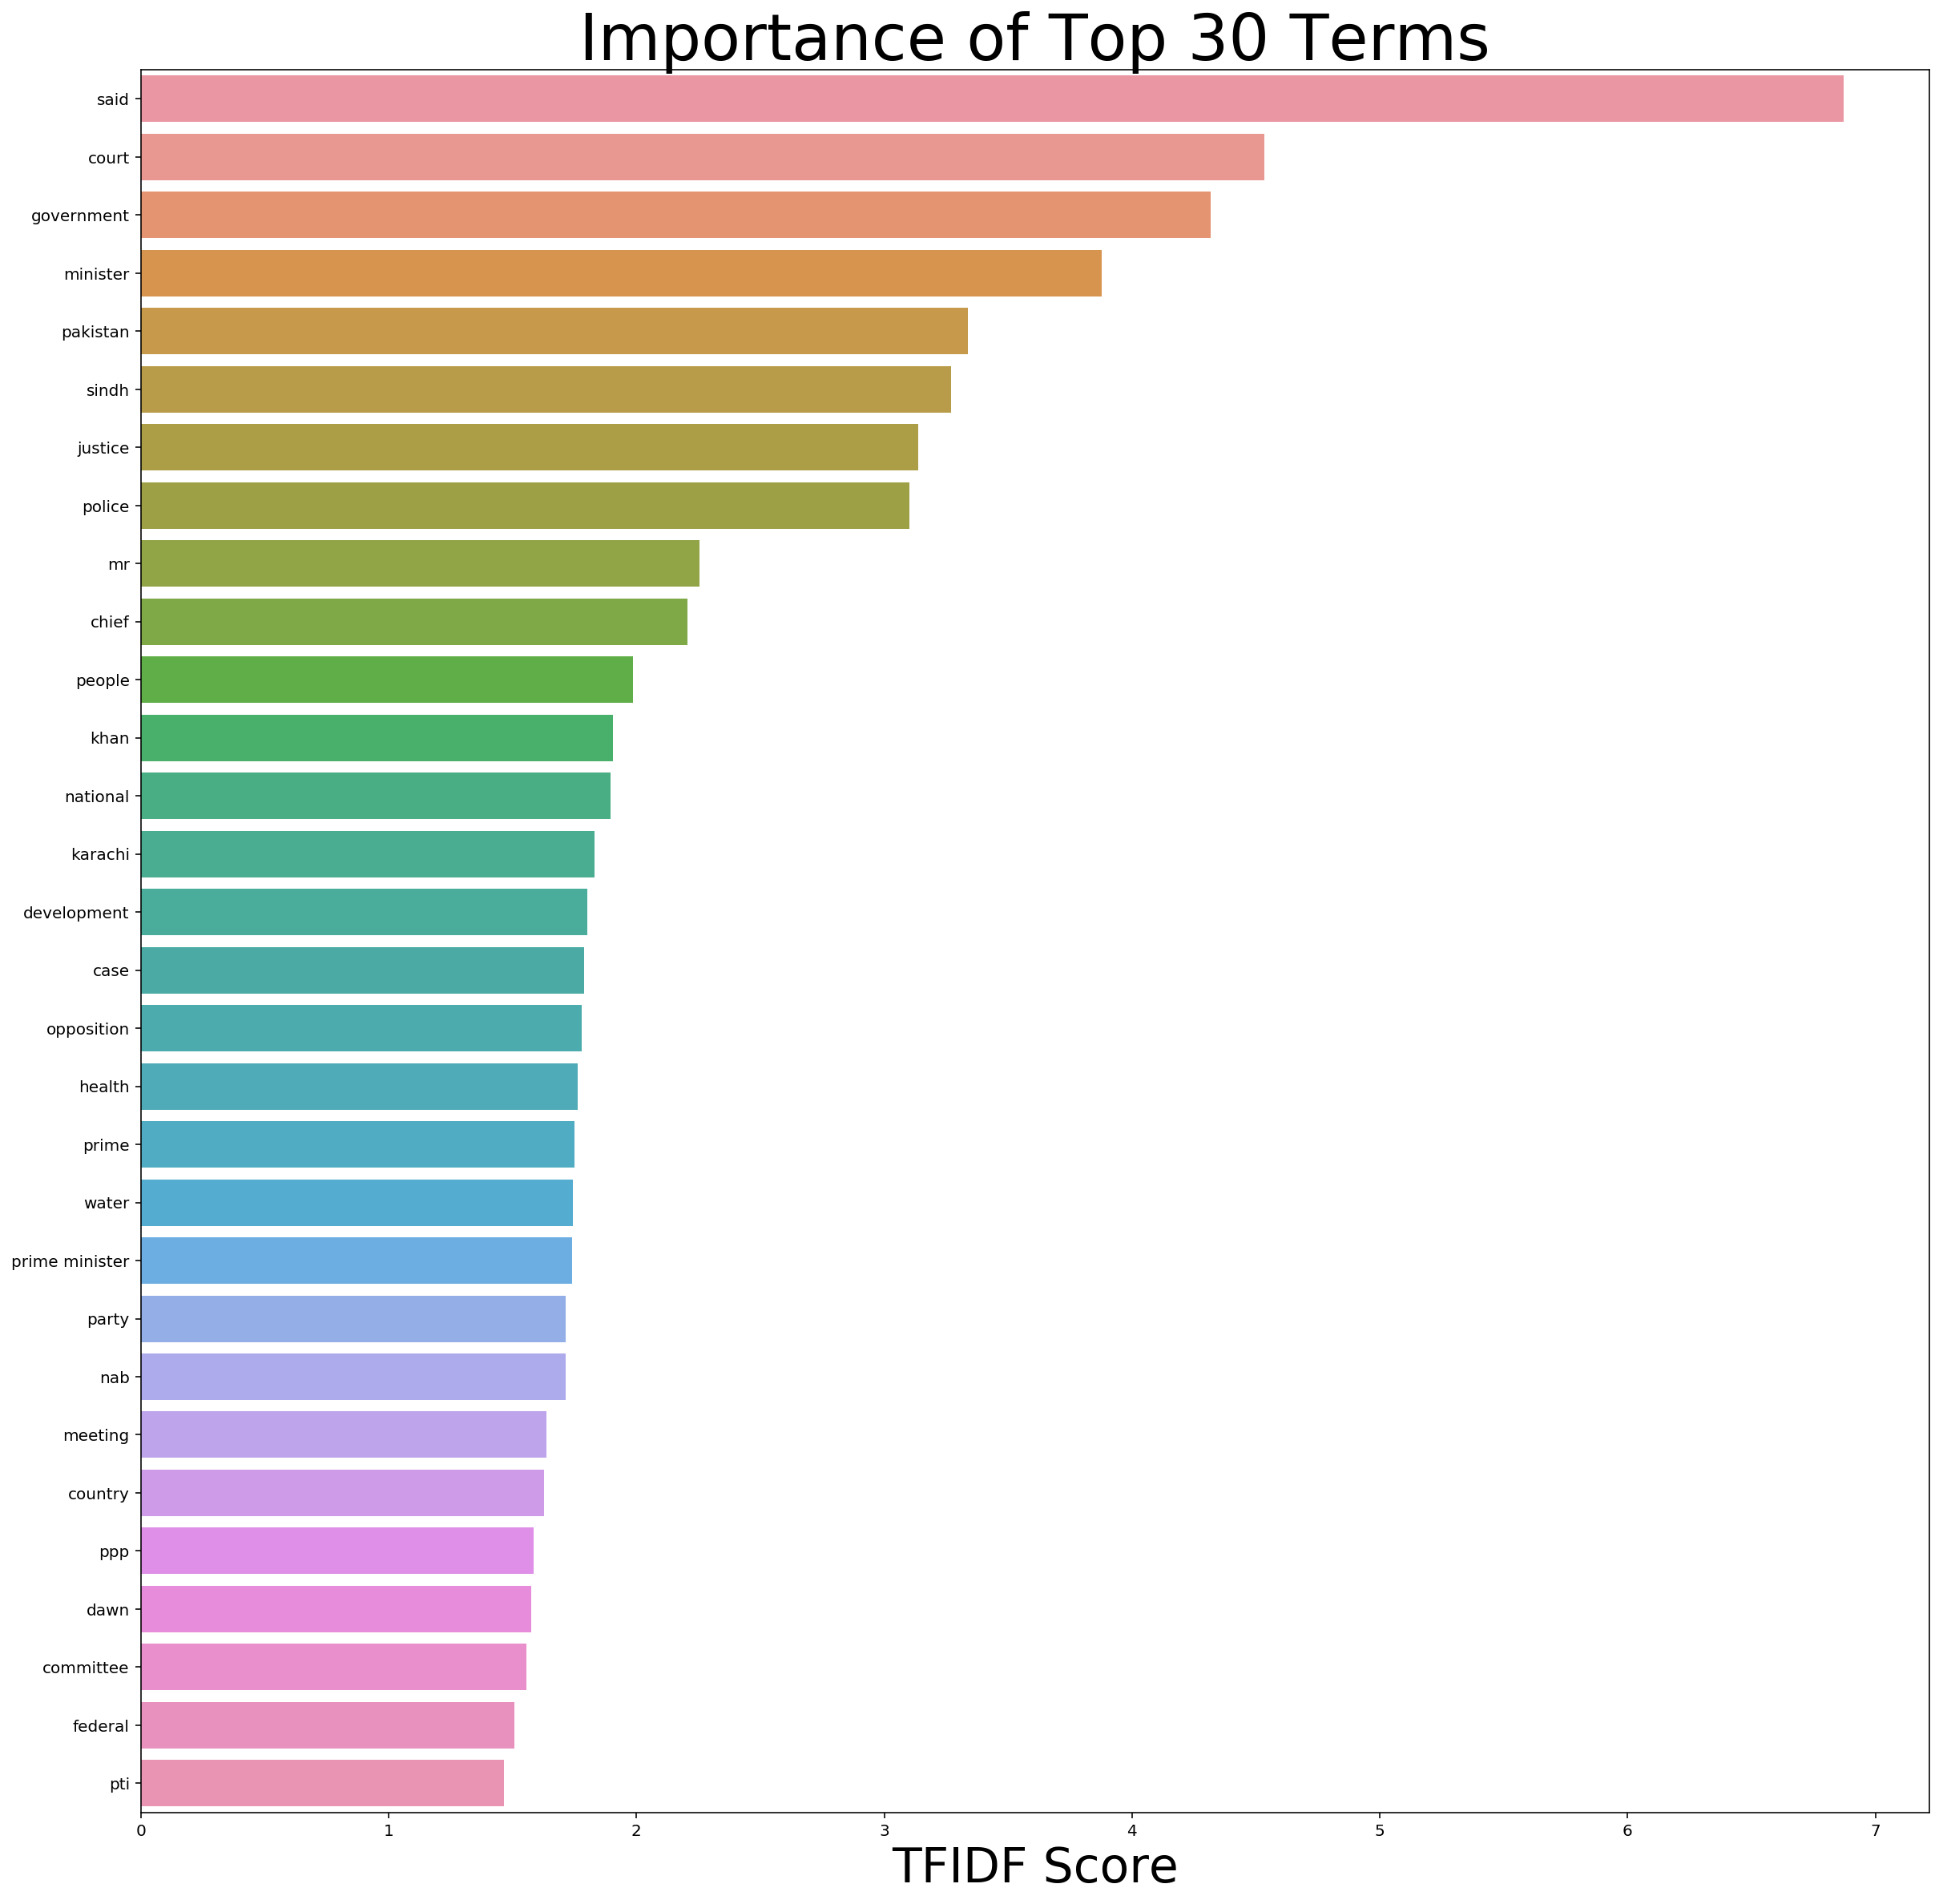

In [38]:
plot(scores, terms, words = 30)

We can see from the above plot that the most common news in the scope of our data is related to goverment,justice, police which comes under the category of politics.

In [39]:
data['Length'] = [len(headline) for headline in data['Headline']]
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label,tokenized_Content,tokenized_Headline,Length
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1,"['thirdyear', 'mbbs', 'student', 'found', 'sho...","['mbbs', 'student', 'found', 'dead', 'hostel',...",73
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1,"['federal', 'cabinet', 'decided', 'remove', 'n...","['govt', 'decides', 'remove', 'names', 'bilawa...",59
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1,"['afghan', 'president', 'ashraf', 'ghani', 'th...","['afghan', 'president', 'thanks', 'pm', 'khan'...",90
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1,"['director', 'script', 'writer', 'wajahat', 'r...","['mehwish', 'hayat', 'acts', 'musical', 'dream...",71
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1,"['complete', 'address', 'justice', 'asif', 'sa...","['complete', 'text', 'address', 'justice', 'as...",94


- From now onwards we will try to find the best model and features according to our data using exhaustive research.

### Grid Search 
- We perform grid search for all the models and features to find the best combination of model, features and hyperparameters.

#### Logistic Regression with TFIDF

In [4]:
X = data.tokenized_Content
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129,)
X_test (33,)
y_train (129,)
y_test (33,)


In [5]:
# max_df is used for removing terms that appear too frequently
# max_df = 0.50 means "ignore terms that appear in more than 50% of the documents"
# min_df is used for removing terms that appear too infrequently
# min_df = 0.01 means "ignore terms that appear in less than 1% of the documents"
parameters = {'lr__penalty': ('l1','l2'),'tfidf__ngram_range': [(1,1),(1,2),(1,3)],'tfidf__max_df': [0.65,0.75,0.85,0.90],
             'tfidf__min_df': [0.001,0.01],'tfidf__stop_words': [ENGLISH_STOP_WORDS]}

In [6]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),('lr', LogisticRegression())])

In [7]:
# These are the parameters we can put in the list for the model and features.
text_clf.get_params().keys()

dict_keys(['memory', 'steps', 'tfidf', 'lr', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [9]:
gs_lr = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1)
gs_lr = gs_lr.fit(X_train, y_train)
predicted = gs_lr.predict(X_test)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [21]:
from sklearn.metrics import precision_recall_fscore_support

In [27]:
print ("Logistig Regression: \n")
print ( "F1 score {:.4}%".format(f1_score(y_test, predicted, average='macro')*100 ) )
print ( "Accuracy score {:.4}%\n\n".format(accuracy_score(y_test, predicted)*100) )
error = mean_squared_error(y_test, predicted)
print('MSE',error)

Logistig Regression: 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score 28.74%
Accuracy score 75.76%


MSE 0.3333333333333333


In [36]:
# Class misrepresentation is extremely unbalanced in the train and test set
print(Counter(y_test))
print(Counter(y_train))

Counter({1: 25, 0: 7, -1: 1})
Counter({1: 89, 0: 37, -1: 3})


In [34]:
# confusion_matrix = cm(y_test, predicted)
# fig, ax = plt.subplots(figsize=(10,5))
# sb.heatmap(confusion_matrix, annot=True, fmt='d')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [201]:
print(metrics.classification_report(y_test, predicted,target_names=['Fake','Unverified','Real']))

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         1
  Unverified       0.00      0.00      0.00         7
        Real       0.76      1.00      0.86        25

   micro avg       0.76      0.76      0.76        33
   macro avg       0.25      0.33      0.29        33
weighted avg       0.57      0.76      0.65        33



In [37]:
# mean score
# print(gs_lr.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))

lr__penalty: 'l1'
tfidf__max_df: 0.65
tfidf__min_df: 0.001
tfidf__ngram_range: (1, 1)
tfidf__stop_words: frozenset({'former', 'him', 'seemed', 'inc', 'before', 'latter', 'least', 'someone', 'eg', 'am', 'see', 'such', 'than', 'other', 'twenty', 'anyone', 'once', 'ten', 'they', 'under', 'through', 'anyhow', 'been', 'whereafter', 'somewhere', 'their', 'latterly', 'many', 'are', 'since', 'neither', 'sincere', 'namely', 'get', 'per', 'couldnt', 'please', 'it', 'so', 'ourselves', 'show', 'thin', 'too', 'whom', 'co', 'might', 'without', 'though', 'if', 'always', 'hundred', 'have', 'indeed', 'another', 'may', 'together', 'were', 'within', 'everywhere', 'already', 'still', 'when', 'of', 'found', 'these', 'her', 'thick', 'also', 'beyond', 'beside', 'by', 'noone', 'nine', 'seem', 'because', 'five', 'formerly', 'much', 'on', 'seems', 'top', 'become', 'more', 'nothing', 'herself', 'interest', 'whose', 'would', 'in', 'same', 'therefore', 'first', 'i', 'made', 'do', 'above', 'me', 'becoming', 'less',

####  SVM with TFIDF

In [95]:
X = data.tokenized_Content
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129,)
X_test (33,)
y_train (129,)
y_test (33,)


In [96]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),('svm', SGDClassifier())])

In [97]:
parameters = {'svm__penalty': ('l1','l2'),'svm__alpha': (1e-2, 1e-3),
              'svm__loss': ('hinge','squared_hinge'),'tfidf__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
             'tfidf__max_df': [0.65,0.75,0.85,0.90],'tfidf__min_df': [0.001,0.01],'tfidf__stop_words': [ENGLISH_STOP_WORDS]}

In [98]:
# Using cross validation
gs_svm = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1)
gs_svm = gs_svm.fit(X_train, y_train)
predicted = gs_svm.predict(X_test)
print ( "Accuracy score {:.4}%".format(accuracy_score(y_test, predicted)*100) )

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy score 63.64%


In [99]:
print(metrics.classification_report(y_test, predicted,target_names=['Fake','Unverified','Real']))

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         1
  Unverified       0.25      0.29      0.27         7
        Real       0.76      0.76      0.76        25

   micro avg       0.64      0.64      0.64        33
   macro avg       0.34      0.35      0.34        33
weighted avg       0.63      0.64      0.63        33



In [101]:
#best mean score
# print(gs_svm.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))

svm__alpha: 0.001
svm__loss: 'hinge'
svm__penalty: 'l2'
tfidf__max_df: 0.9
tfidf__min_df: 0.01
tfidf__ngram_range: (1, 2)
tfidf__stop_words: frozenset({'former', 'him', 'seemed', 'inc', 'before', 'latter', 'least', 'someone', 'eg', 'am', 'see', 'such', 'than', 'other', 'twenty', 'anyone', 'once', 'ten', 'they', 'under', 'through', 'anyhow', 'been', 'whereafter', 'somewhere', 'their', 'latterly', 'many', 'are', 'since', 'neither', 'sincere', 'namely', 'get', 'per', 'couldnt', 'please', 'it', 'so', 'ourselves', 'show', 'thin', 'too', 'whom', 'co', 'might', 'without', 'though', 'if', 'always', 'hundred', 'have', 'indeed', 'another', 'may', 'together', 'were', 'within', 'everywhere', 'already', 'still', 'when', 'of', 'found', 'these', 'her', 'thick', 'also', 'beyond', 'beside', 'by', 'noone', 'nine', 'seem', 'because', 'five', 'formerly', 'much', 'on', 'seems', 'top', 'become', 'more', 'nothing', 'herself', 'interest', 'whose', 'would', 'in', 'same', 'therefore', 'first', 'i', 'made', 'do'

#### Experiment 1 : Best model for Logistic Regression with TFIDF
- Text to Features: TFIDF using the article content (Try different n grams)
- Classification Model: Logistic Regression (Different penalties)
- Check different metrics and ROC curve. Confusion matrix.


In [40]:
X = data.tokenized_Content
y = data['Label']

In [42]:
tdf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,1),max_df =0.65,min_df=0.001)
vectorizer = tdf.fit(X)
transformed_text = vectorizer.transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(transformed_text,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129, 9154)
X_test (33, 9154)
y_train (129,)
y_test (33,)


In [44]:
lr = LogisticRegression(penalty='l1')

In [45]:
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [46]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_test, prediction , average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_test, prediction)*100) )

Logistig Regression F1 and Accuracy Scores : 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score 28.74%
Accuracy score 75.76%


#### Experiment 1 : Best model for SVM with TFIDF
- Text to Features: TFIDF using the article content
- Classification Model: SVM 

- Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive. Should be the metric when there os a high cost associated with False Positive.
- Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.
- For our model both of them are equally important.
- F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. F1 is more useful than accuracy especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 
- F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [102]:
X = data.tokenized_Content
y = data['Label']

In [103]:
tdf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,4),max_df =0.85,min_df=0.01)
vectorizer = tdf.fit(X)
transformed_text = vectorizer.transform(X)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(transformed_text,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129, 7718)
X_test (33, 7718)
y_train (129,)
y_test (33,)


In [105]:
svm = SGDClassifier(alpha= 0.001,loss ='hinge',penalty='l2')

In [106]:
svm.fit(X_train, y_train)
prediction = svm.predict(X_test)

In [110]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_test, prediction , average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_test, prediction)*100) )
error = mean_squared_error(y_test, predicted)
print('MSE',error)

Logistig Regression F1 and Accuracy Scores : 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score 41.74%
Accuracy score 72.73%
MSE 0.45454545454545453


In [108]:
print(metrics.classification_report(y_test, prediction,target_names=['Fake','Unverified','Real']))

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         1
  Unverified       0.43      0.43      0.43         7
        Real       0.81      0.84      0.82        25

   micro avg       0.73      0.73      0.73        33
   macro avg       0.41      0.42      0.42        33
weighted avg       0.70      0.73      0.71        33



In [94]:
# Function from scikit-learn
def plot_learning_curve(estimator, title, X, y, ylim, cv,
                        n_jobs, train_sizes=(50,70,100)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

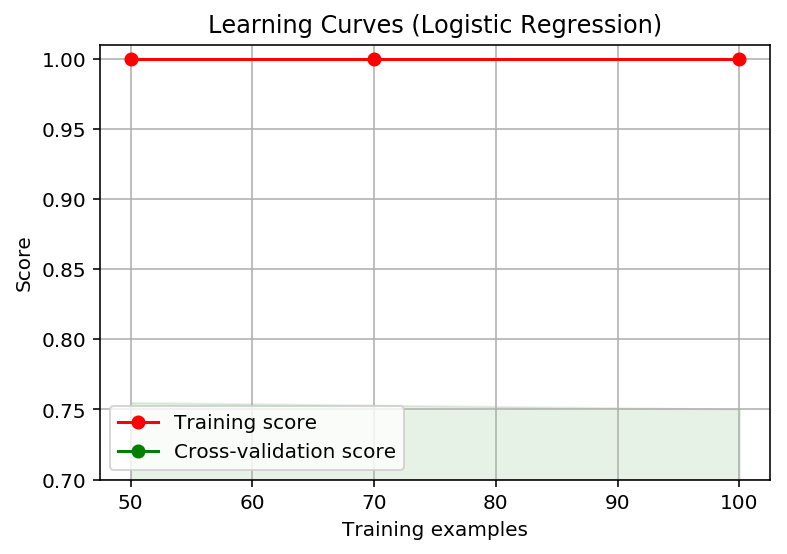

In [109]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(svm, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()